# Import

In [1]:
from diffusion_proj.util.storage import STORAGE_DIR, save, load
from diffusion_proj.util.datetime import eta, clock
from diffusion_proj.models.base.debugging import get_tensor_info
from diffusion_proj.util.fancy_text import cmod, Fore

from array import array
from torch import Tensor
from torchvision import transforms
from numpy import ndarray as CPUArray
from matplotlib.pyplot import Axes
from typing import Union
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import struct
import random
import matplotlib.pyplot as plt

# PyTorch globals

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE  = torch.float32
SEED = 100
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Load MNIST data

In [3]:
class MnistDataloader(object):
    def __init__(self, train_images_filepath: str, train_labels_filepath: str, eval_images_filepath: str, eval_labels_filepath: str):
        self.train_images_filepath = train_images_filepath
        self.train_labels_filepath = train_labels_filepath
        self.eval_images_filepath = eval_images_filepath
        self.eval_labels_filepath = eval_labels_filepath

    @staticmethod
    def read_images_labels(images_filepath: str, labels_filepath: str, max_records: int = None,
                           resize: tuple[int, int] = None, rand_rot=False, rand_flip=False, batch_size=64,
                           device=torch.device('cpu'), dtype=torch.float32):
        # Load images
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images_: list[CPUArray] = []
        for i in range(size):
            images_.append(
                [0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            # sys.exit(0)
            images_[i][:] = img
        images = torch.tensor(np.stack(images_), device='cpu', dtype=torch.float32).unsqueeze(1)

        # Load Labels
        labels_: list[int] = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels_ = array("B", file.read())
        labels = torch.tensor(labels_, device='cpu', dtype=torch.long)

        if max_records is not None:
            images, labels = images[:max_records], labels[:max_records]

        # Filter some transforms for specific labels
        def get_indices(exclusions: Union[int, list[int]]):
            if isinstance(exclusions, (int, float)):
                exclusions = [exclusions]
            return [x for x in range(len(labels)) if labels[x].item() not in exclusions]

        # Modify in batches
        def get_batches(indices_to_group: list[int], batch_size: int = None, shuffle=False):
            records = len(indices_to_group)
            if batch_size is None:
                batch_size = records
            assert records > 0
            if batch_size is None:
                batch_size = records
            else:
                assert batch_size > 0
                batch_size = min(batch_size, records)

            indices: list[int] = indices_to_group
            if shuffle:
                random.shuffle(indices)
            batch_indices: list[list[int]] = list()
            batch: list[int] = list()
            for i, index in enumerate(indices):
                batch.append(index)
                batch_is_filled = len(batch) == batch_size
                no_more_records = i == len(indices) - 1 and not batch_is_filled
                if batch_is_filled or no_more_records:
                    batch_indices.append(batch)
                    batch = list()

            return batch_indices

        # Resizing
        if resize is not None:
            transformation = transforms.Resize(resize)
            images = transformation(images)
        # Random Flips
        if rand_flip:
            for batch in get_batches(get_indices([2, 4, 5, 6, 7, 9]), batch_size, True):
                h_flip = transforms.RandomHorizontalFlip(p=0.5)
                v_flip = transforms.RandomVerticalFlip(p=0.5)
                images[batch] = v_flip(h_flip(images[batch]))
        # Random Rotations
        if rand_rot:
            rotations90 = [(-30, 30)]
            for batch in get_batches(get_indices([6, 9]), batch_size, True):
                images[batch] = transforms.RandomRotation(random.choice(rotations90))(images[batch])
            # rotations180 = [(0, 0), (180, 180)]
            # for batch in get_batches(get_indices([2, 4, 5, 6, 7, 9]), batch_size, True):
            #     images[batch] = transforms.RandomRotation(random.choice(rotations180))(images[batch])

        print(f"Loaded {len(images)} records.")
        return images.to(device, dtype), labels.to(device)

    def load_data(self, train_records: int = None, eval_records: int = None, resize: tuple[int, int] = None,
                  rand_rot=False, rand_flip=False, batch_size=64,
                  device=torch.device('cpu'), dtype=torch.float32):
        train_inp, train_out = self.read_images_labels(
            self.train_images_filepath, self.train_labels_filepath,
            train_records, resize, rand_rot, rand_flip, batch_size,
            device, dtype
        )
        eval_inp, eval_out = self.read_images_labels(
            self.eval_images_filepath, self.eval_labels_filepath,
            eval_records, resize, False, False, None,
            device, dtype
        )
        return (train_inp, train_out), (eval_inp, eval_out)

In [4]:
DATA_PATH = f"{STORAGE_DIR}example_data/mnist/"

# Load MNIST dataset
mnist_dataloader = MnistDataloader(
    f"{DATA_PATH}train-images.idx3-ubyte",
    f"{DATA_PATH}train-labels.idx1-ubyte",
    f"{DATA_PATH}t10k-images.idx3-ubyte",
    f"{DATA_PATH}t10k-labels.idx1-ubyte",
)
(train_inp, train_out), (eval_inp, eval_out) = mnist_dataloader.load_data(
    40000, 4000, resize=(28, 28), rand_rot=False, rand_flip=False, batch_size=512, device=DEVICE, dtype=DTYPE
)
train_inp.shape, train_out.shape, eval_inp.shape, eval_out.shape

Loaded 40000 records.
Loaded 4000 records.


(torch.Size([40000, 1, 28, 28]),
 torch.Size([40000]),
 torch.Size([4000, 1, 28, 28]),
 torch.Size([4000]))

In [5]:
train_inp.device, train_inp.dtype, train_inp.device, train_out.dtype

(device(type='cuda', index=0),
 torch.float32,
 device(type='cuda', index=0),
 torch.int64)

In [6]:
IMAGE_SHAPE = tuple(train_inp.shape[-2:])
IMAGE_SHAPE

(28, 28)

In [7]:
# def check_crossover():
#     ts = clock.perf_counter()
#     units_total = test_dataset[0].shape[0]
#     count = 0
#     with torch.no_grad():
#         for x, test_point in enumerate(test_dataset[0]):
#             test_point = test_point.unsqueeze(0).expand(train_dataset[0].shape)
#             if torch.any(torch.all(torch.all(test_point == train_dataset[0], -1), -1)):
#                 count += 1
#             eta(ts, x+1, units_total)
#     return count
# check_crossover()

# View data

In [8]:
def show_image(image: Tensor, title: str = None, size: tuple[int, int] = None, cmap='binary', axis: Axes = None):
    if size is None:
        size = (360, 360)
    if image.ndim == 3:
        image = image.permute(1, 2, 0)
    elif image == 2:
        pass
    else:
        raise ValueError(f"Unsupported ndim")
    image = image.cpu()
    if axis is None:
        _, axis = plt.subplots(1, 1, figsize=(size[0] * 0.01, size[1] * 0.01))
    axis.imshow(image, cmap=cmap)
    if title is not None:
        axis.set_title(title)
    axis.set_axis_off()
    if axis is None:
        plt.show()

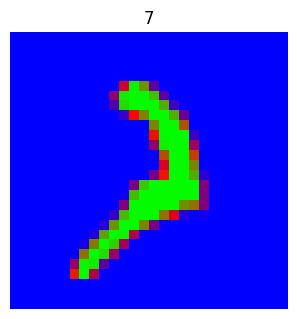

In [9]:
rand_train_idx = np.random.randint(0, len(train_inp))
show_image(train_inp[rand_train_idx], train_out[rand_train_idx].item(), cmap='brg')

In [10]:
def show_batch(images: Tensor, predictions: Tensor = None, labels: Tensor = None, columns=8,
               size: tuple[int, int] = None, cmap='binary', no_axes=True):
    if size is None:
        size = (720, 1080)
    if images.ndim == 4:
        images = images.permute(0, 2, 3, 1)
    elif images == 3:
        pass
    else:
        raise ValueError(f"Unsupported ndim")

    images = images.cpu()
    rows = math.ceil(len(images) / columns)
    fig, axes = plt.subplots(rows, columns, figsize=(size[1] * 0.01, size[0] * 0.01))
    if isinstance(axes, CPUArray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for index, (axis, image) in enumerate(zip(axes, images)):
        axis.imshow(image, cmap=cmap)
        title = ''
        if predictions is not None:
            title += f"P={predictions[index].cpu().item()}"
        if labels is not None:
            title += f"L={labels[index].cpu().item()}"
        if len(title) > 0:
            axis.set_title(title)
        if no_axes:
            axis.set_axis_off()
    plt.show()

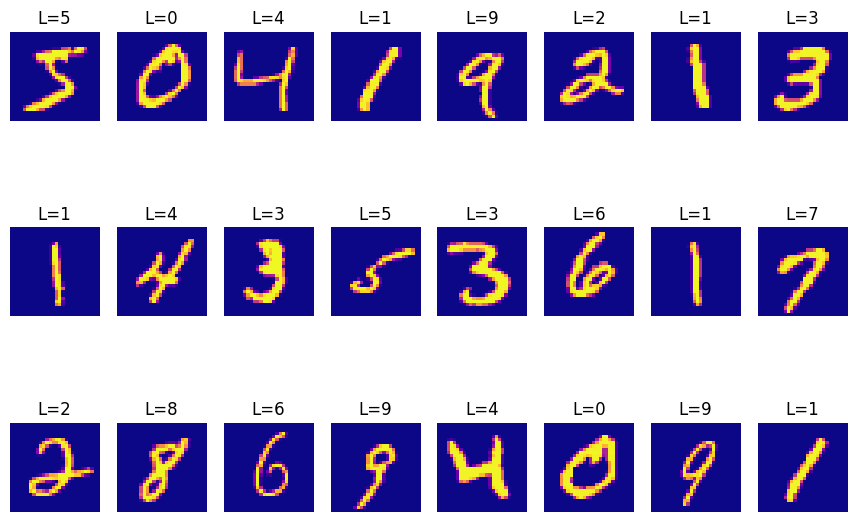

In [11]:
show_batch(train_inp[:24], labels=train_out[:24], cmap='plasma')

In [12]:
def plot_noise_distribution(noise: Tensor, predicted_noise: Tensor, alpha=0.8, size: tuple[int, int] = None):
    if size is None:
        size = (360, 720)
    _, axis = plt.subplots(1, 1, figsize=(size[1]*0.01, size[0]*0.01))
    axis.hist(noise.cpu().numpy().flatten(), density=True, alpha=alpha, label="ground truth noise")
    axis.hist(predicted_noise.cpu().numpy().flatten(), density=True, alpha=alpha, label="predicted noise")
    plt.legend()
    plt.show()

# Diffusion Model

In [13]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 1500):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def forward(self, images: Tensor, time_steps: Tensor, device: torch.device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(images)
        # print(f"Noise = {noise.shape}")
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), time_steps, images.shape)
        # print(f"TSteps Sqrt of CumProd of Alpha = {sqrt_alphas_cumprod_t.shape}")
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), time_steps, images.shape)
        # print(f"TSteps Sqrt of NegCumProd of Alpha = {sqrt_alphas_cumprod_t.shape}")

        mean = sqrt_alphas_cumprod_t.to(device) * images.to(device)
        # print(f"Mean = {mean.shape}")
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        # print(f"Variance = {variance.shape}")
        noisy_images = mean + variance
        # print(f"Noise Imeages = {noisy_images.shape}")
        # noisy_x = (noisy_x - noisy_x.min()) / (noisy_x.max() - noisy_x.min())

        return noisy_images, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

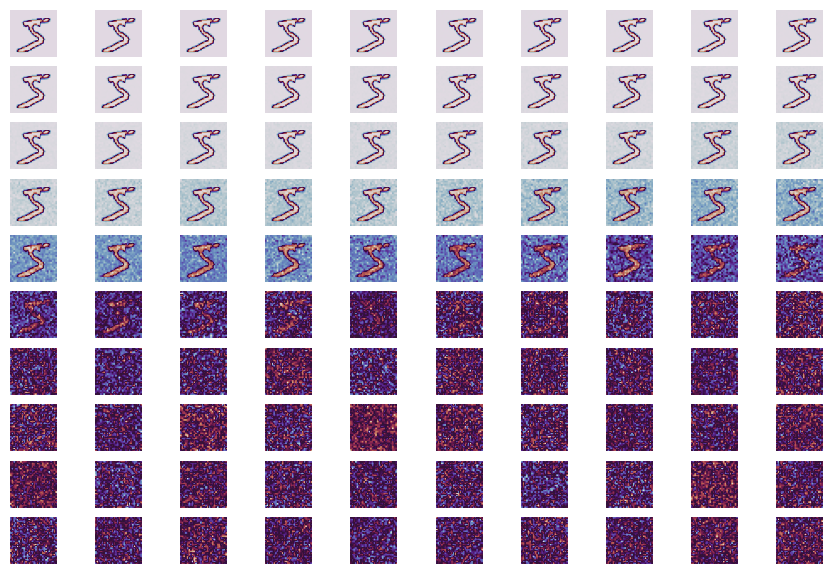

In [14]:
MODEL = DiffusionModel(1e-2, 6e-1, timesteps=100)

NO_DISPLAY_IMAGES = 100
with torch.no_grad():
    test_image = train_inp[0]
    torch_image_batch = torch.stack([test_image] * NO_DISPLAY_IMAGES)
    test_timesteps = torch.linspace(0, MODEL.timesteps - 1, NO_DISPLAY_IMAGES).long()
    noisy_image_batch, _ = MODEL.forward(torch_image_batch, test_timesteps, DEVICE)
    show_batch(noisy_image_batch, columns=10, cmap=plt.cm.twilight)

MEAN = torch.mean(torch_image_batch)
STD  = torch.std(torch_image_batch)

In [15]:
def calc_padding(kernel_size: int, stride=1, dilation=1):
    return math.ceil(((kernel_size - 1) * dilation - (stride - 1)) / 2)

In [16]:
class ResBlock(nn.Module):
    def __init__(self, inputs: int, outputs: int, kernel_size: int, time_embeddings: int, label_embeddings: int = None,
                 stride=2, downsample=True, padding_mode='circular', bias=False):
        super().__init__()
        assert stride <= 2

        # Build - Time
        self.time_embedding = nn.Embedding(time_embeddings, outputs)
        # Build - Labels
        self.label_embedding = nn.Embedding(label_embeddings, outputs) if label_embeddings is not None else None
        # Build - Convolution
        padding_in      = calc_padding(kernel_size, stride)
        padding_out     = calc_padding(kernel_size, 1)
        self.norm1      = nn.BatchNorm2d(inputs)
        if downsample:
            self.inp_proj = nn.Conv2d(inputs, outputs, kernel_size=kernel_size, stride=stride, padding=padding_in, padding_mode=padding_mode, bias=bias)
            self.res_proj = nn.Conv2d(inputs, outputs, kernel_size=1, stride=stride, bias=bias) \
                if outputs != inputs or stride > 1 else None
        else:
            self.inp_proj = nn.ConvTranspose2d(inputs, outputs, kernel_size=kernel_size, stride=stride, padding=padding_in, output_padding=stride//2, padding_mode='zeros', bias=bias)
            self.res_proj = nn.ConvTranspose2d(inputs, outputs, kernel_size=1, stride=stride, padding=0, output_padding=stride//2, padding_mode='zeros', bias=bias) \
                if outputs != inputs or stride > 1 else None
        self.mul_proj   = nn.Conv2d(outputs, outputs, kernel_size=kernel_size, padding=padding_out, padding_mode=padding_mode, bias=bias)
        self.norm2      = nn.BatchNorm2d(outputs)
        self.out_proj   = nn.Conv2d(outputs, outputs, kernel_size=kernel_size, padding=padding_out, padding_mode=padding_mode, bias=bias)
        self.actv       = nn.SiLU()

        # Attributes
        self.input_dims     = inputs
        self.output_dims    = outputs
        self.kernel_size    = kernel_size
        self.stride         = stride
        self.bias           = bias
        self.downsample     = downsample
        self.upsample       = not downsample
        self.labels         = label_embeddings is not None

    def forward(self, image: Tensor, time_step: Tensor, **kwargs):
        verbose = kwargs.get('verbose')
        if verbose:
            print(f"Input Image = {image.shape}")
            if verbose >= 2:
                print(f"Input Timestep = {time_step.shape}")
        tensor_images = self.inp_proj(self.norm1(image))
        if verbose:
            print(f"Image Tensor = {tensor_images.shape}")
        tensor_time = self.time_embedding(time_step)
        if verbose:
            print(f"Time Embedding = {tensor_time.shape}")
        tensor_images = tensor_images + tensor_time.view(*tensor_time.shape, 1, 1)
        batch_labels = kwargs.get('labels')
        if self.labels and batch_labels is not None:
            if verbose and verbose >= 2:
                print(f"Labels Tensor = {batch_labels.shape}")
            tensor_labels = self.label_embedding(batch_labels)
            if verbose:
                print(f"Label Embedding = {tensor_labels.shape}")
            tensor_images = tensor_images + tensor_labels.view(*tensor_labels.shape, 1, 1)
        tensor_images = self.actv(self.mul_proj(self.norm2(self.actv(tensor_images))))
        if verbose:
            print(f"Image Tensor = {tensor_images.shape}")
        continuous_residual = image if self.res_proj is None else self.res_proj(image)
        level_residual = kwargs.get('residual')
        if self.upsample and level_residual is not None:
            if verbose and verbose >= 2:
                print(f"Level Residual = {level_residual.shape}")
            continuous_residual = level_residual if self.res_proj is None else self.res_proj(level_residual)
        if verbose:
            print(f"Residual = {continuous_residual.shape}")
        tensor_images = self.out_proj(tensor_images)
        if verbose:
            print(cmod(f"Output Image = {tensor_images.shape}", Fore.MAGENTA))
        tensor_images = tensor_images + continuous_residual
        return tensor_images

    def __repr__(self):
        return f"{self.__class__.__name__}({self.input_dims}, {self.output_dims}, kernel_size={self.kernel_size}, stride={self.stride}, " \
               f"bias={self.bias}, timesteps={self.time_embedding}, labels={self.label_embedding}, atcv={self.actv}, downsample={self.downsample})"

In [17]:
with torch.no_grad():
    test_tensor  = torch.randn(3, 64, 28, 28)
    test_timesteps = torch.randint(0, MODEL.timesteps, (3,))
    test_labels = torch.randint(0, 10, (3,))
    print(test_timesteps, MODEL.timesteps)
    test_block = ResBlock(inputs=64, outputs=32, kernel_size=3, time_embeddings=MODEL.timesteps, label_embeddings=10,
                          stride=2, downsample=False, padding_mode='replicate')
    print(test_block)
    test_out = test_block.forward(test_tensor, test_timesteps, labels=test_labels,
                                  verbose=True, residual=torch.randn_like(test_tensor))
    print(test_out.shape)

tensor([49, 99,  5]) 100
ResBlock(64, 32, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 32), labels=Embedding(10, 32), atcv=SiLU(), downsample=False)
Input Image = torch.Size([3, 64, 28, 28])
Image Tensor = torch.Size([3, 32, 56, 56])
Time Embedding = torch.Size([3, 32])
Label Embedding = torch.Size([3, 32])
Image Tensor = torch.Size([3, 32, 56, 56])
Residual = torch.Size([3, 32, 56, 56])
Output Image = torch.Size([3, 32, 56, 56])
torch.Size([3, 32, 56, 56])


In [18]:
class UNet(nn.Module):
    def __init__(self, img_channels: int, kernel_size: int, sequence_channels: Union[int, list[int]],
                 time_embeddings: int, label_embeddings: int = None, layers: Union[int, list[int]] = 1,
                 kernel_size_init: Union[int, None] = 7, padding_mode='circular', bias=False,
                 device='cpu', dtype=torch.float32):
        super().__init__()
        if isinstance(sequence_channels, (int, float)):
            sequence_channels = [int(sequence_channels)]
        if isinstance(sequence_channels, tuple):
            sequence_channels = list(sequence_channels)
        if isinstance(layers, (int, float)):
            layers = [layers for _ in range(len(sequence_channels)-1)]
        layers = layers[:len(sequence_channels)]
        if kernel_size_init is None:
            kernel_size_init = kernel_size

        self.encode = nn.Conv2d(img_channels, sequence_channels[0], kernel_size=kernel_size_init,
                                stride=1, padding=calc_padding(kernel_size_init, 1), bias=bias,
                                padding_mode=padding_mode)
        self.pre_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.down_sampling: list[ResBlock] = nn.ModuleList()
        for seq_idx, (channels_in, channels_out) in enumerate(zip(sequence_channels, sequence_channels[1:])):
            for layer_idx in range(layers[seq_idx]):
                self.down_sampling.append(
                    ResBlock(channels_in if layer_idx == 0 else channels_out, channels_out,
                             kernel_size, time_embeddings, label_embeddings, stride=2 if layer_idx == 0 else 1,
                             downsample=True, padding_mode=padding_mode, bias=bias)
                )
        self.up_sampling: list[ResBlock] = nn.ModuleList()
        sequence_reverse = sequence_channels[::-1]
        for seq_idx, (channels_in, channels_out) in enumerate(zip(sequence_reverse, sequence_reverse[1:])):
             for layer_idx in range(layers[seq_idx]):
                 self.up_sampling.append(
                     ResBlock(channels_in, channels_out if layer_idx == layers[seq_idx]-1 else channels_in,
                              kernel_size, time_embeddings, label_embeddings, stride=2 if layer_idx == layers[seq_idx]-1 else 1,
                              downsample=False, padding_mode=padding_mode, bias=bias)
                 )
        self.norm = nn.BatchNorm2d(sequence_channels[0])
        # self.post_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.decode = nn.Conv2d(sequence_channels[0], img_channels, kernel_size, 1, calc_padding(kernel_size, 1),
                                padding_mode=padding_mode, bias=bias)
        self.to(device, dtype)
        self.eval()

        # Attributes
        self.img_channels       = img_channels
        self.seq_channels: list[int] = list(sequence_channels)
        self.layers: list[int]  = layers
        self.kernel_size        = kernel_size
        self.kernel_size_init   = kernel_size_init
        self.bias               = bias
        self.time_embeddings    = time_embeddings
        self.label_embeddings   = label_embeddings

    def forward(self, images: Tensor, timesteps: Tensor, **kwargs):
        assert images.ndim >= 3 and timesteps.ndim == 1
        verbose = kwargs.get('verbose')
        level_residuals: list[Tensor] = []
        if verbose:
            print(cmod(f"Input Images = {images.shape}", Fore.CYAN))
        tensor = self.encode(images)
        tensor = F.silu(self.pre_pool(tensor) + tensor)
        if verbose:
            print(cmod(f"Encoded Images = {tensor.shape}", Fore.CYAN))
        for i, ds in enumerate(self.down_sampling):
            try:
                tensor = ds(tensor, timesteps, **kwargs)
            except RuntimeError as e:
                print(cmod(f"On Module {ds}, ie: Step {i}, last_shape={tensor.shape}", Fore.LIGHTYELLOW_EX))
                raise e
            level_residuals.append(tensor)
        if verbose:
            print(cmod(f"UNet Bottom Images = {tensor.shape}", Fore.CYAN))
        for i, (us, res) in enumerate(zip(self.up_sampling, reversed(level_residuals))):
            try:
                kwargs['residual'] = res # if i != 0 else None
                tensor = us(tensor, timesteps, **kwargs)
            except RuntimeError as e:
                print(cmod(f"On Module {us}, ie: Step {i}, last_shape={tensor.shape}", Fore.LIGHTYELLOW_EX))
                raise e
        tensor = self.decode(self.norm(tensor))
        if verbose:
            print(cmod(f"Decoded Images = {tensor.shape}", Fore.CYAN))
        return tensor

    def save(self, file_no: int = None):

        name = f"params_globals-i{self.img_channels}-s{tuple([d for d in self.seq_channels])}-" \
               f"l{tuple([l for l in self.layers])}-k{self.kernel_size}-ki{self.kernel_size_init}-b{self.bias}-" \
               f"t{self.time_embeddings}-a{self.label_embeddings}"
        params = self.state_dict()
        save(params, name, 'mnist_diffusion_models', subdirectory=f"{self.__class__.__name__}", file_no=file_no)

    def load(self, file_no: int = None):
        name = f"params_globals-i{self.img_channels}-s{tuple([d for d in self.seq_channels])}-" \
               f"l{tuple([l for l in self.layers])}-k{self.kernel_size}-ki{self.kernel_size_init}-b{self.bias}-" \
               f"t{self.time_embeddings}-a{self.label_embeddings}"
        params = load(name, 'mnist_diffusion_models', subdirectory=f"{self.__class__.__name__}", file_no=file_no)
        if params is not None:
            self.load_state_dict(params)

In [19]:
with torch.no_grad():
    test_tensor  = torch.randn(3, 1, 32, 32)
    test_timesteps = torch.randint(0, MODEL.timesteps, (3,))
    test_labels = torch.randint(0, 10, (3,))
    test_block = UNet(1, 3, sequence_channels=(16, 32, 48), time_embeddings=MODEL.timesteps, label_embeddings=11,
                      layers=2, kernel_size_init=7, padding_mode='circular',)
    print(test_block)
    test_out = test_block.forward(test_tensor, test_timesteps, labels=test_labels, verbose=2)
    print(test_out.shape)
    # test_block.save()
    # test_block.load()

UNet(
  (encode): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False, padding_mode=circular)
  (pre_pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (down_sampling): ModuleList(
    (0): ResBlock(16, 32, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 32), labels=Embedding(11, 32), atcv=SiLU(), downsample=True)
    (1): ResBlock(32, 32, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 32), labels=Embedding(11, 32), atcv=SiLU(), downsample=True)
    (2): ResBlock(32, 48, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 48), labels=Embedding(11, 48), atcv=SiLU(), downsample=True)
    (3): ResBlock(48, 48, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 48), labels=Embedding(11, 48), atcv=SiLU(), downsample=True)
  )
  (up_sampling): ModuleList(
    (0): ResBlock(48, 48, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 48), labels=Embedding(11, 48), atcv=SiLU(), d

# Create Trial Model

In [579]:
LR = 1e-3

unet = UNet(1, 3, sequence_channels=(64, 128, 256), time_embeddings=MODEL.timesteps,
            label_embeddings=100, bias=False,
            layers=2, kernel_size_init=7, padding_mode='zeros', device=DEVICE, dtype=DTYPE)
for param in unet.parameters():
    if param.ndim >= 2:
        nn.init.kaiming_uniform_(param)
    else:
        with torch.no_grad():
            param = 1

optimizer = torch.optim.AdamW(unet.parameters(), lr=LR, weight_decay=0e-4)

In [580]:
unet

UNet(
  (encode): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (pre_pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (down_sampling): ModuleList(
    (0): ResBlock(64, 128, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 128), labels=Embedding(100, 128), atcv=SiLU(), downsample=True)
    (1): ResBlock(128, 128, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 128), labels=Embedding(100, 128), atcv=SiLU(), downsample=True)
    (2): ResBlock(128, 256, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 256), labels=Embedding(100, 256), atcv=SiLU(), downsample=True)
    (3): ResBlock(256, 256, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 256), labels=Embedding(100, 256), atcv=SiLU(), downsample=True)
  )
  (up_sampling): ModuleList(
    (0): ResBlock(256, 256, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 256), labels=Embedding(100, 256), atcv=SiLU(), 

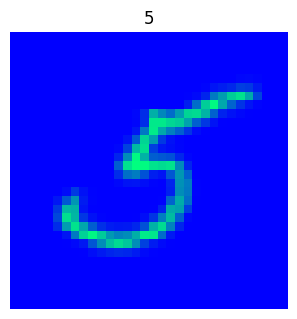

In [554]:
test_train_idx = random.randint(0, len(train_inp))
test_image, test_label = train_inp[test_train_idx], train_out[test_train_idx]
show_image(test_image, title=f"{test_label.cpu().item()}", cmap=plt.cm.winter)

---
Epoch: 0 | Train Loss 6483982.276436942


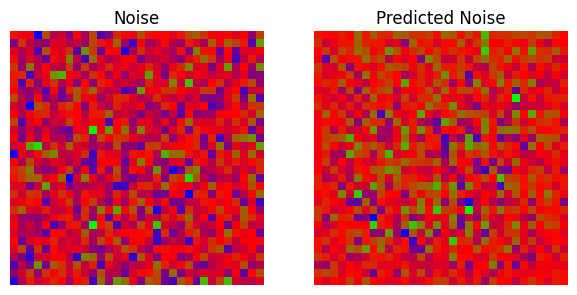

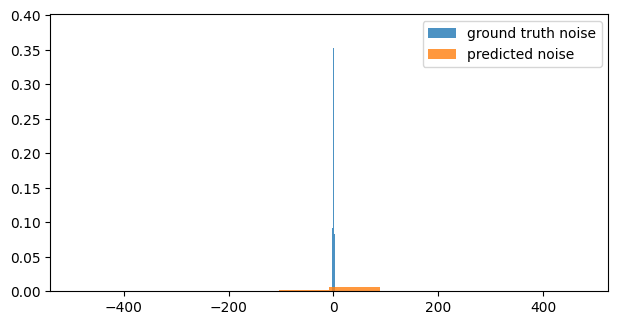

training loss = 2.547e-01 | 25% | eta=110s | ---
Epoch: 250 | Train Loss 0.25858100184372496


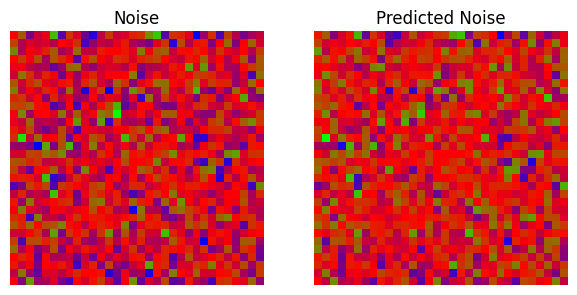

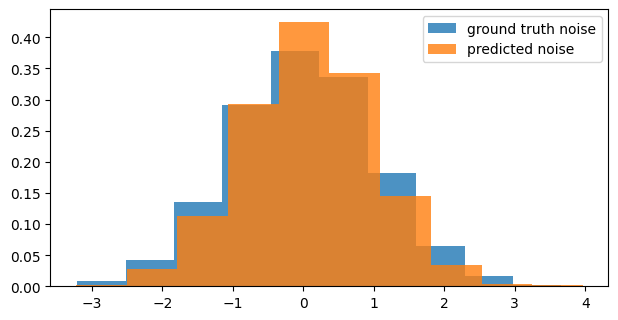

training loss = 1.033e-01 | 50% | eta=71s |  ---
Epoch: 500 | Train Loss 0.09730832970568112


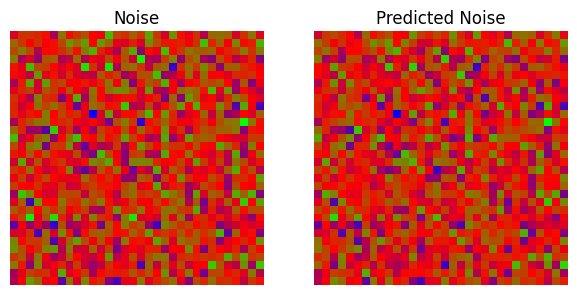

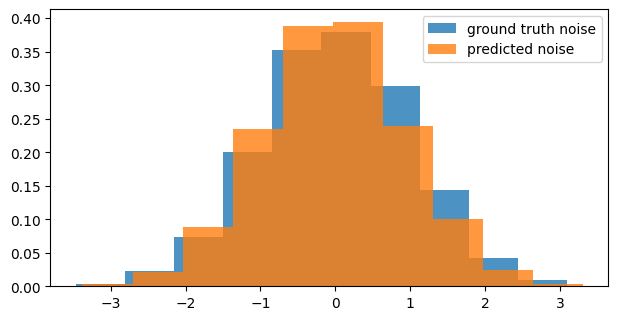

training loss = 6.088e-02 | 75% | eta=36s | ---
Epoch: 750 | Train Loss 0.06069259984152658


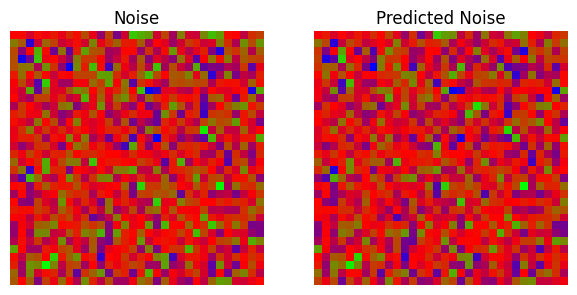

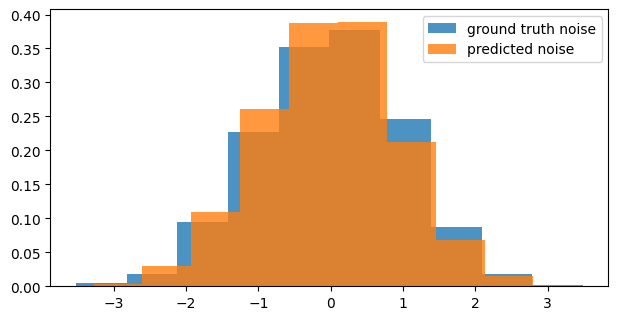

training loss = 5.183e-02 | 100% | eta=0s | ---
Epoch: 999 | Train Loss 0.052106532135180066


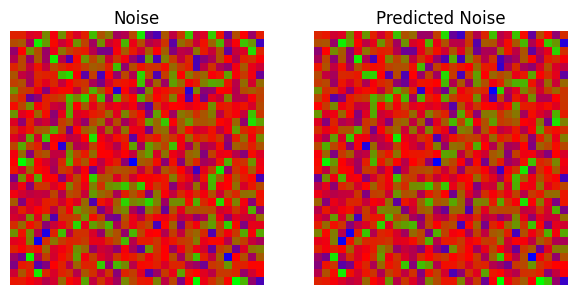

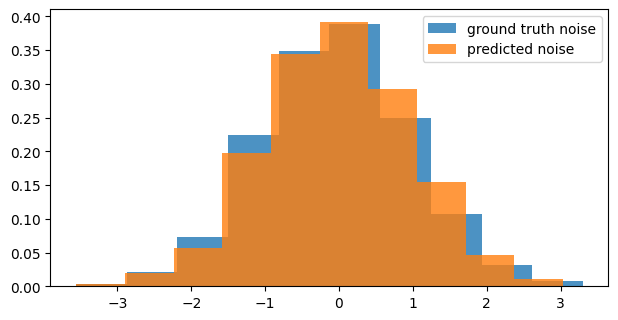

training loss = 5.211e-02 | 100% | eta=0s | 

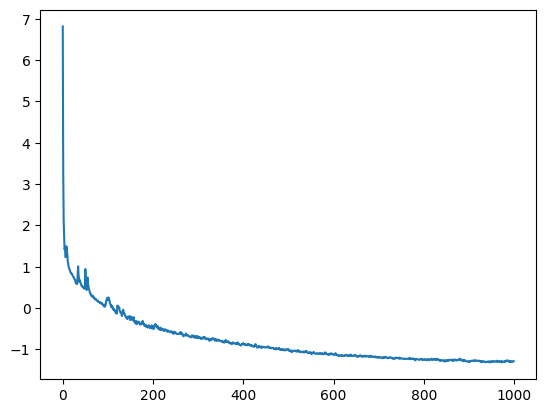

In [581]:
NO_EPOCHS = 1000
PRINT_FREQUENCY = NO_EPOCHS // 4
BATCH_SIZE = 16
VERBOSE = True

def trial_train(clip_grad: float = None):
    torch.cuda.empty_cache()
    batch_indices = get_batches(MODEL.timesteps, BATCH_SIZE, True)
    test_batch = torch.stack([test_image] * BATCH_SIZE)
    test_batch_labels = torch.stack([test_label] * BATCH_SIZE)
    test_timesteps = torch.linspace(0, MODEL.timesteps-1, MODEL.timesteps, device=DEVICE, dtype=torch.long)
    losses = []
    ts = clock.perf_counter()
    state_dict = deepcopy(unet.state_dict())
    best_loss = np.inf
    for epoch in range(NO_EPOCHS):
        mean_epoch_loss = []
        for batch in batch_indices:
            test_batch_inp = test_batch[:len(batch)]
            test_batch_out = test_batch_labels[:len(batch)]
            test_timestep_inp = test_timesteps[batch]
            batch_noisy, noise = MODEL.forward(test_batch_inp, test_timestep_inp, DEVICE)
            predicted_noise = unet.forward(batch_noisy, test_timestep_inp, labels=test_batch_out)

            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(noise, predicted_noise)
            mean_epoch_loss.append(loss.item())
            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(unet.parameters(), clip_grad)
            optimizer.step()
        mean_epoch_loss = np.mean(mean_epoch_loss)

        if epoch % PRINT_FREQUENCY == 0 or epoch == NO_EPOCHS-1:
            print('---')
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
            if VERBOSE:
                with torch.no_grad():
                    _, test_axes = plt.subplots(1, 2, figsize=(720*0.01, 360*0.01))
                    test_axes = test_axes.flatten()
                    CMAP = 'brg'
                    show_image(noise[0], 'Noise', axis=test_axes[0], cmap=CMAP)
                    show_image(predicted_noise[0], 'Predicted Noise', axis=test_axes[1], cmap=CMAP)
                    plot_noise_distribution(noise, predicted_noise)

        if mean_epoch_loss < best_loss:
            best_loss = mean_epoch_loss
            state_dict = deepcopy(unet.state_dict())

        losses.append(mean_epoch_loss)
        eta(ts, epoch+1, NO_EPOCHS, f'training loss = {mean_epoch_loss:.3e}')
    unet.load_state_dict(state_dict)

    plt.plot(np.log10(losses))
    plt.show()
    torch.cuda.empty_cache()
trial_train(1)

tensor([5], device='cuda:0')
On step 100/100 | 100% | eta=0s | torch.Size([6, 1, 32, 32])


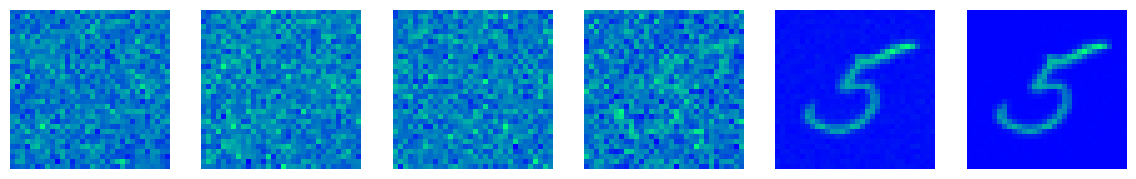

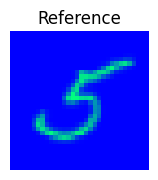

In [601]:
with torch.no_grad():
    img = torch.randn((1, 1) + IMAGE_SHAPE).to(DEVICE)
    lbl = test_label.unsqueeze(0) # torch.full((1,), 50, device=DEVICE, dtype=torch.long) #
    ts, ud, ut = clock.perf_counter(), 0, MODEL.timesteps
    print_steps = np.round(np.linspace(0, MODEL.timesteps-1, 6-1)).tolist()
    test_image_gen = [img]
    print(lbl)
    for i in reversed(range(MODEL.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=DEVICE)
        img = MODEL.backward(img, t, unet.eval(), labels=lbl)
        if i in print_steps:
            test_image_gen.append(img)
        ud += 1
        eta(ts, ud, ut, f"On step {ud}/{ut}")
    test_image_gen = torch.cat(test_image_gen)
    print(test_image_gen.shape)
    CMAP = plt.cm.winter
    show_batch(test_image_gen, columns=(len(test_image_gen))//1, cmap=CMAP, size=(480, 1440))
    show_image(test_image, cmap=CMAP, title='Reference', size=(180, 180))

# Create Full Model

In [20]:
def get_batches(records: int, batch_size: int = None, shuffle=False):
    if batch_size is None:
        batch_size = records
    assert records > 0
    if batch_size is None:
        batch_size = records
    else:
        assert batch_size > 0
        batch_size = min(batch_size, records)

    indices: list[int] = list(range(records))
    if shuffle:
        random.shuffle(indices)
    batch_indices: list[list[int]] = list()
    batch: list[int] = list()
    for i, index in enumerate(indices):
        batch.append(index)
        batch_is_filled = len(batch) == batch_size
        no_more_records = i == len(indices) - 1 and not batch_is_filled
        if batch_is_filled or no_more_records:
            batch_indices.append(batch)
            batch = list()

    return batch_indices

In [21]:
LR              = 1e-3
VERBOSE         = True

In [22]:
unet = UNet(1, 3, sequence_channels=(64, 128, 256), time_embeddings=MODEL.timesteps,
            label_embeddings=100, bias=False,
            layers=2, kernel_size_init=7, padding_mode='zeros', device=DEVICE, dtype=DTYPE)
unet.to(DEVICE)
min_loss = None
for param in unet.parameters():
    if param.ndim >= 2:
        nn.init.kaiming_uniform_(param)

In [23]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=LR, weight_decay=01e-6)

In [24]:
unet.load()

Successfully loaded  save file from 'D:\Python Projects\diffusion/storage/mnist_diffusion_models/UNet/params_globals-i1-s(64, 128, 256)-l(2, 2)-k3-ki7-bFalse-t100-a100.pkl'.


In [25]:
unet

UNet(
  (encode): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (pre_pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (down_sampling): ModuleList(
    (0): ResBlock(64, 128, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 128), labels=Embedding(100, 128), atcv=SiLU(), downsample=True)
    (1): ResBlock(128, 128, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 128), labels=Embedding(100, 128), atcv=SiLU(), downsample=True)
    (2): ResBlock(128, 256, kernel_size=3, stride=2, bias=False, timesteps=Embedding(100, 256), labels=Embedding(100, 256), atcv=SiLU(), downsample=True)
    (3): ResBlock(256, 256, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 256), labels=Embedding(100, 256), atcv=SiLU(), downsample=True)
  )
  (up_sampling): ModuleList(
    (0): ResBlock(256, 256, kernel_size=3, stride=1, bias=False, timesteps=Embedding(100, 256), labels=Embedding(100, 256), atcv=SiLU(), 

# Train

training: loss=inf best_loss=inf best_epoch=-1 | 0% | eta=6008s |  ---
Epoch: 0 | Train Loss 1.007e-01 | Val Loss 9.866e-02


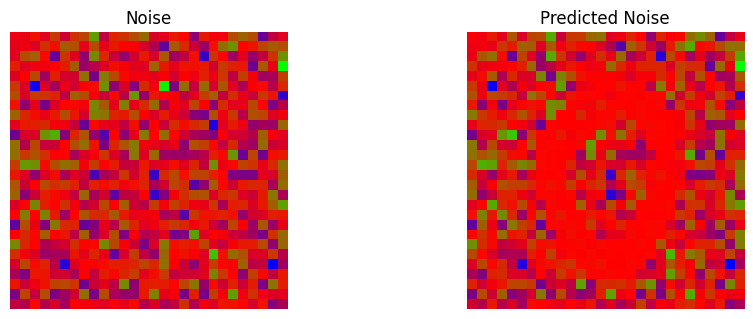

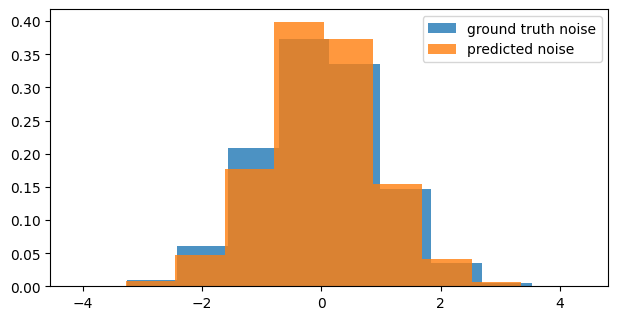

training: loss=9.48e-02 best_loss=9.19e-02 best_epoch=30 | 17% | eta=5294s | ---
Epoch: 33 | Train Loss 9.460e-02 | Val Loss 9.181e-02


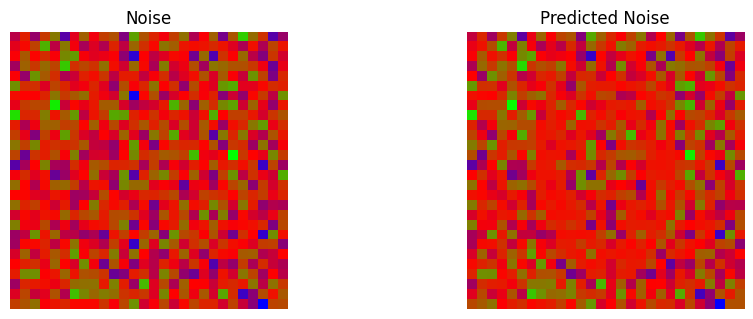

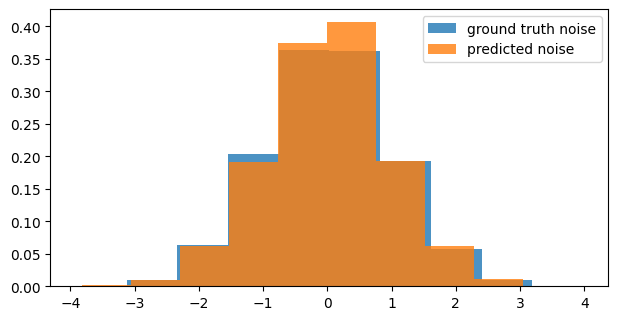

training: loss=9.13e-02 best_loss=9.02e-02 best_epoch=65 | 33% | eta=4206s | ---
Epoch: 66 | Train Loss 9.136e-02 | Val Loss 9.007e-02


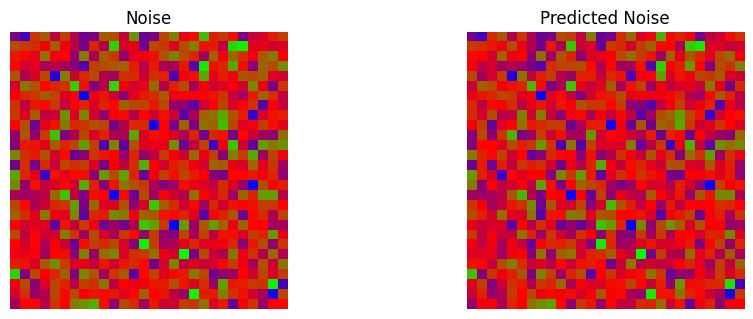

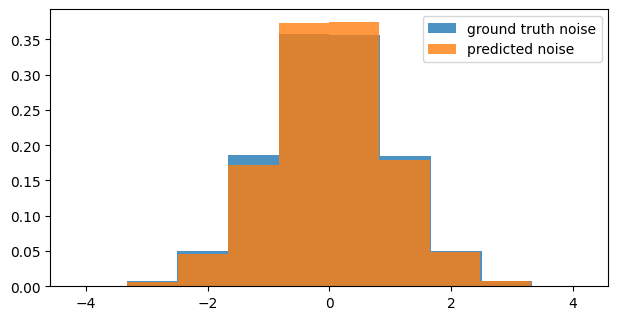

training: loss=9.10e-02 best_loss=8.95e-02 best_epoch=68 | 35% | eta=4096s | 

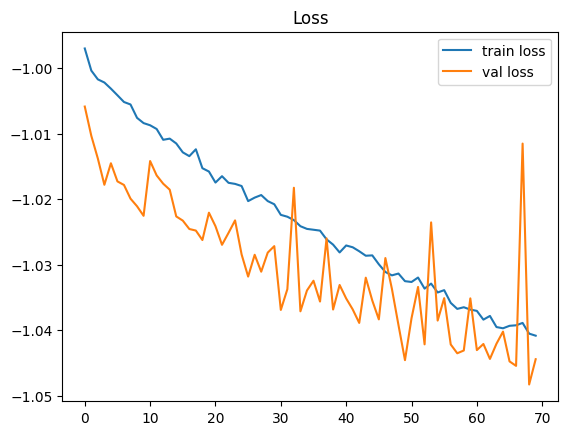

In [26]:
NO_EPOCHS = 200
PRINT_FREQUENCY = NO_EPOCHS // 6
BATCH_SIZE = 64

def train(clip_grad: float = None):
    torch.cuda.empty_cache()

    timesteps = torch.linspace(0, MODEL.timesteps-1, MODEL.timesteps, device=DEVICE, dtype=torch.long)
    train_batches = get_batches(len(train_inp), BATCH_SIZE, True)
    eval_batches = get_batches(len(eval_inp), BATCH_SIZE, True)
    step_batches = get_batches(BATCH_SIZE * math.ceil(MODEL.timesteps/BATCH_SIZE), BATCH_SIZE, True)
    step_batches = [[idx if idx < (MODEL.timesteps-1) else idx - (MODEL.timesteps-1) for idx in batch] for batch in step_batches]

    train_losses = []
    val_losses   = []

    train_ts = clock.perf_counter()
    state_dict = deepcopy(unet.state_dict())
    best_loss = np.inf
    best_epoch = -1
    try:
        prev_loss = np.inf
        for epoch in range(NO_EPOCHS):
            unet.train()
            mean_epoch_loss = []
            for idx, train_batch in enumerate(train_batches):
                step_batch = step_batches[(epoch*len(train_batches)+idx) % len(step_batches)]
                random.shuffle(step_batch)
                batch = train_inp[train_batch]
                label = train_out[train_batch]
                timestep = timesteps[step_batch][:len(batch)]
                # print(batch.shape, label.shape, timestep.shape)

                batch_noisy, noise = MODEL.forward(batch, timestep, DEVICE)
                predicted_noise = unet(batch_noisy, timestep, labels=label)

                optimizer.zero_grad()
                loss = torch.nn.functional.mse_loss(noise, predicted_noise)
                mean_epoch_loss.append(loss.item())
                loss.backward()
                if clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(unet.parameters(), clip_grad)
                optimizer.step()

                eta(train_ts, (epoch*(len(train_batches)+len(eval_batches)))+idx+1,
                    NO_EPOCHS*(len(train_batches)+len(eval_batches)), f'training: loss={prev_loss:.2e} '
                               f'best_loss={best_loss:.2e} '
                               f'best_epoch={best_epoch}')
            mean_epoch_loss = np.mean(mean_epoch_loss).item()
            prev_loss = mean_epoch_loss

            unet.eval()
            mean_epoch_loss_val = []
            with torch.no_grad():
                for idx, eval_batch in enumerate(eval_batches):
                    step_batch = step_batches[(epoch*len(eval_batches)+idx) % len(step_batches)]
                    random.shuffle(step_batch)
                    batch = eval_inp[eval_batch]
                    label = eval_out[eval_batch]
                    timestep = timesteps[step_batch][:len(batch)]

                    batch_noisy, noise = MODEL.forward(batch, timestep, DEVICE)
                    predicted_noise = unet(batch_noisy, timestep, labels=label)

                    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
                    mean_epoch_loss_val.append(loss.item())
            mean_epoch_loss_val = np.mean(mean_epoch_loss_val).item()

            if epoch % PRINT_FREQUENCY == 0 or epoch == NO_EPOCHS-1:
                print('---')
                print(f"Epoch: {epoch} | Train Loss {mean_epoch_loss:.3e} | Val Loss {mean_epoch_loss_val:.3e}")
                if VERBOSE:
                    with torch.no_grad():
                        _, test_axes = plt.subplots(1, 2, figsize=(1080*0.01, 360*0.01))
                        test_axes = test_axes.flatten()
                        CMAP = 'brg'
                        show_image(noise[0], 'Noise', axis=test_axes[0], cmap=CMAP)
                        show_image(predicted_noise[0], 'Predicted Noise', axis=test_axes[1], cmap=CMAP)
                        plot_noise_distribution(noise, predicted_noise)
                        plt.show()

                torch.save(unet.state_dict(), f".\\saves\\temp_save-{epoch}")

            if best_loss is None or mean_epoch_loss_val < best_loss:
                state_dict = deepcopy(unet.state_dict())
                best_epoch = epoch
                best_loss = mean_epoch_loss_val

            train_losses.append(mean_epoch_loss)
            val_losses.append(mean_epoch_loss_val)
    except KeyboardInterrupt:
        pass
    unet.load_state_dict(state_dict)

    plt.plot(np.log10(train_losses), label='train loss')
    plt.plot(np.log10(val_losses), label='val loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

    unet.train()
    torch.cuda.empty_cache()
train(clip_grad=None)

In [79]:
# unet = UNet(labels=True)
# unet.load_state_dict(f".\\saves\\temp_save-{epoch}"))

In [27]:
classes = [i for i in range(10)]

In [28]:
NUM_CLASSES = 10
NUM_DISPLAY_IMAGES = 10

In [29]:
train_out[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], device='cuda:0')

Fetching 1 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


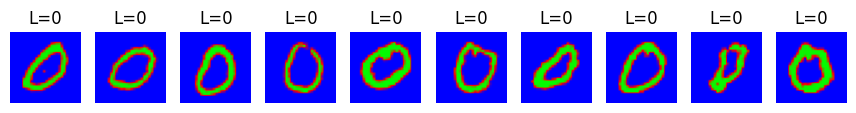

Fetching 2 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


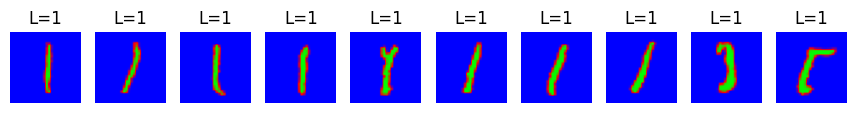

Fetching 3 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


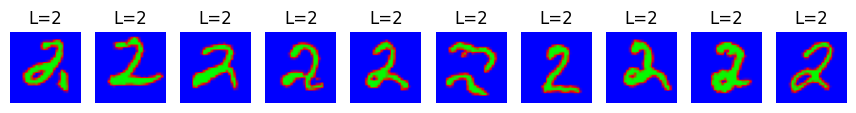

Fetching 4 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


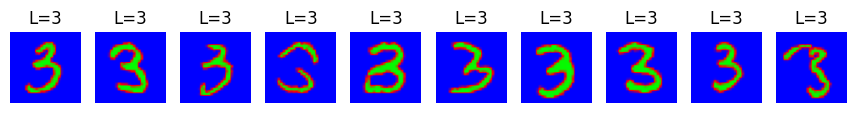

Fetching 5 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


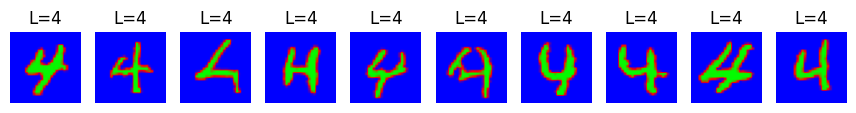

Fetching 6 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


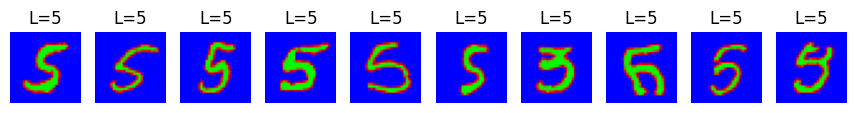

Fetching 7 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


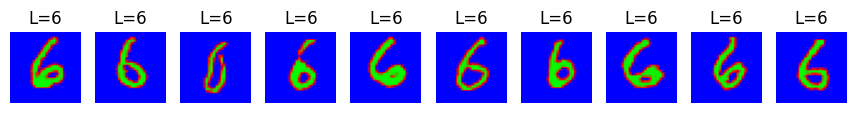

Fetching 8 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


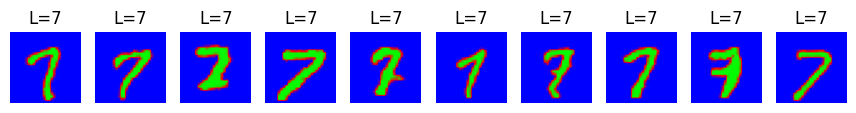

Fetching 9 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


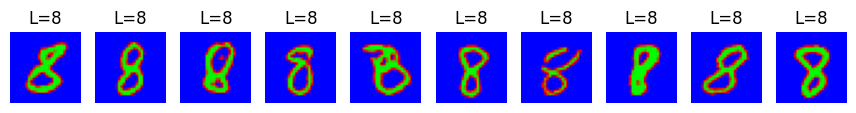

Fetching 10 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


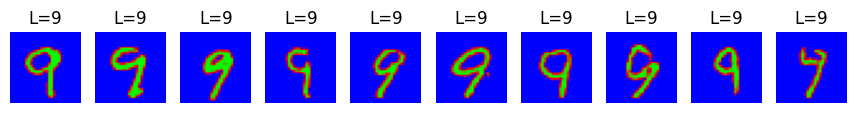

In [30]:
torch.cuda.empty_cache()
for c in range(NUM_CLASSES):
    # imgs = torch.normal(MEAN, STD * 1., (NUM_DISPLAY_IMAGES, 1) + IMAGE_SHAPE).to(DEVICE)
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 1) + IMAGE_SHAPE).to(DEVICE)
    with torch.no_grad():
        fetch_ts = clock.perf_counter()
        labels = torch.full((NUM_DISPLAY_IMAGES,), c, device=DEVICE, dtype=torch.long)
        for i in reversed(range(MODEL.timesteps)):
            t = torch.full((1,), i, dtype=torch.long, device=DEVICE)
            # print(imgs.shape, labels.shape, t.shape)
            imgs = MODEL.backward(x=imgs, t=t, model=unet.eval(), labels=labels)
            eta(fetch_ts, MODEL.timesteps-i, MODEL.timesteps, f"Fetching {c+1}")
    print(imgs.shape)
    plt.close()
    show_batch(imgs, labels=torch.full((NUM_DISPLAY_IMAGES,), c), columns=NUM_DISPLAY_IMAGES, cmap='brg')
    plt.show()

plt.show()

In [31]:
unet.save()

Successfully dumped  save file to 'D:\Python Projects\diffusion/storage/mnist_diffusion_models/UNet/params_globals-i1-s(64, 128, 256)-l(2, 2)-k3-ki7-bFalse-t100-a100-1.pkl'.


Fetching 1 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


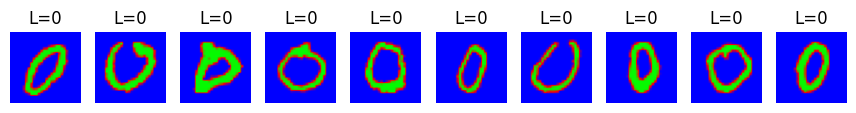

Fetching 2 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


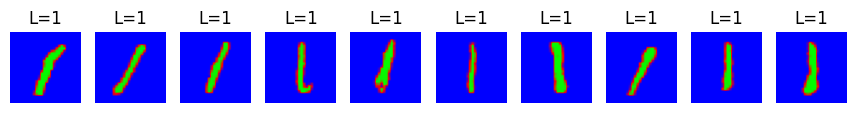

Fetching 3 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


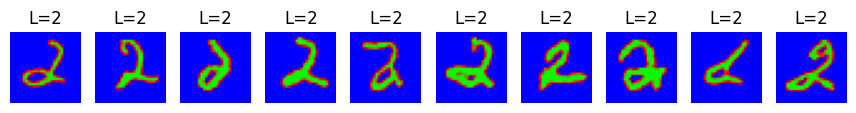

Fetching 4 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


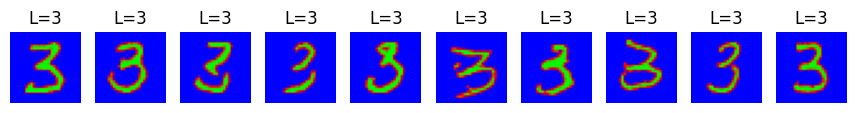

Fetching 5 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


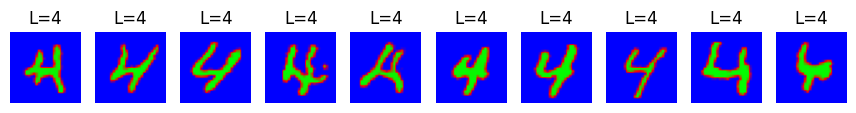

Fetching 6 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


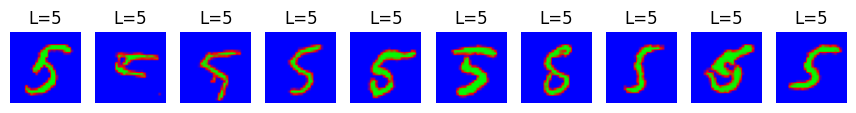

Fetching 7 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


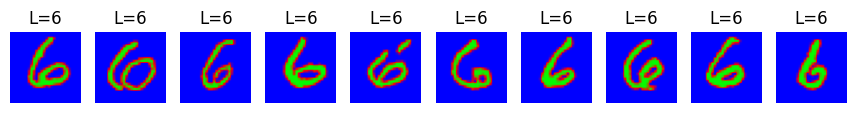

Fetching 8 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


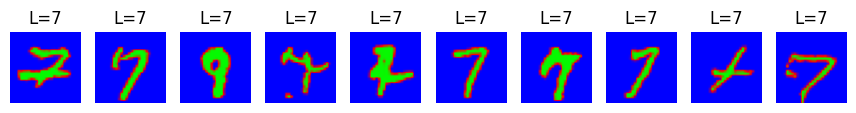

Fetching 9 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


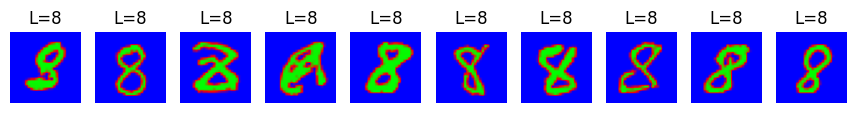

Fetching 10 | 100% | eta=0s | torch.Size([10, 1, 28, 28])


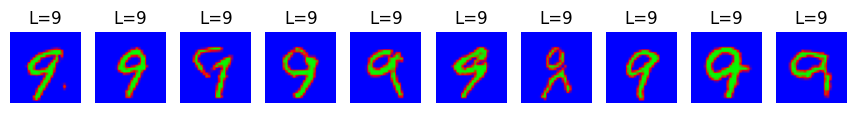

In [33]:
torch.cuda.empty_cache()
for c in range(NUM_CLASSES):
    # imgs = torch.normal(MEAN, STD * 1., (NUM_DISPLAY_IMAGES, 1) + IMAGE_SHAPE).to(DEVICE)
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 1) + IMAGE_SHAPE).to(DEVICE)
    with torch.no_grad():
        fetch_ts = clock.perf_counter()
        labels = torch.full((NUM_DISPLAY_IMAGES,), c, device=DEVICE, dtype=torch.long)
        for i in reversed(range(MODEL.timesteps)):
            t = torch.full((1,), i, dtype=torch.long, device=DEVICE)
            # print(imgs.shape, labels.shape, t.shape)
            imgs = MODEL.backward(x=imgs, t=t, model=unet.eval(), labels=labels)
            eta(fetch_ts, MODEL.timesteps-i, MODEL.timesteps, f"Fetching {c+1}")
    print(imgs.shape)
    plt.close()
    show_batch(imgs, labels=torch.full((NUM_DISPLAY_IMAGES,), c), columns=NUM_DISPLAY_IMAGES, cmap='brg')
    plt.show()

plt.show()

In [141]:
import os

if not os.path.exists(f".\\saves"):
    os.makedirs(f".\\saves")

torch.save(unet.state_dict(), f".\\saves\\best-{5}")